In [19]:
# Import statements
import json
import numpy as np
import matplotlib as mtplb
import matplotlib.pyplot as plt

In [25]:
# Opening JSON file
f = open('hailey_george.json',)
   
# returns JSON object as 
# a dictionary
data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

assert(len(im1_points) == len(im2_points))
   
# Closing file
f.close()

In [26]:
mean_points = np.add(im1_points, im2_points)/2
print(mean_points)
x = np.take(mean_points, 0, axis=1)
y = np.take(mean_points, 1, axis=1)

[[  2.5   1.5]
 [592.    1.5]
 [  2.5 740. ]
 [592.5 739. ]
 [304.5  31. ]
 [186.5  50.5]
 [110.5 109.5]
 [ 78.  194. ]
 [ 62.  345.5]
 [ 64.5 441.5]
 [136.  535. ]
 [183.  601.5]
 [255.5 656.5]
 [364.5 649.5]
 [428.5 598. ]
 [478.  527. ]
 [538.  440.5]
 [542.5 338. ]
 [531.5 214. ]
 [462.5 115. ]
 [396.5  45. ]
 [301.5 109.5]
 [193.  133. ]
 [140.  222. ]
 [115.  333. ]
 [118.5 446. ]
 [415.5 137. ]
 [468.  229. ]
 [492.  325.5]
 [490.5 431.5]
 [253.  280.5]
 [162.5 274.5]
 [132.  318.5]
 [173.5 294.5]
 [336.5 277. ]
 [425.  268.5]
 [463.  313. ]
 [421.5 290. ]
 [294.  310.5]
 [275.  355. ]
 [319.  356.5]
 [300.5 422. ]
 [246.  436.5]
 [350.5 437.5]
 [300.5 456. ]
 [300.  504. ]
 [218.5 517. ]
 [300.5 552.5]
 [386.  510. ]
 [301.5 528. ]
 [303.  598.5]
 [165.  339. ]
 [208.5 331.5]
 [246.5 338.5]
 [355.  333. ]
 [391.  325. ]
 [424.5 331. ]
 [177.  496. ]
 [428.5 479. ]
 [186.5 406. ]
 [420.  395.5]]


In [27]:
print(x)
print(y)

[  2.5 592.    2.5 592.5 304.5 186.5 110.5  78.   62.   64.5 136.  183.
 255.5 364.5 428.5 478.  538.  542.5 531.5 462.5 396.5 301.5 193.  140.
 115.  118.5 415.5 468.  492.  490.5 253.  162.5 132.  173.5 336.5 425.
 463.  421.5 294.  275.  319.  300.5 246.  350.5 300.5 300.  218.5 300.5
 386.  301.5 303.  165.  208.5 246.5 355.  391.  424.5 177.  428.5 186.5
 420. ]
[  1.5   1.5 740.  739.   31.   50.5 109.5 194.  345.5 441.5 535.  601.5
 656.5 649.5 598.  527.  440.5 338.  214.  115.   45.  109.5 133.  222.
 333.  446.  137.  229.  325.5 431.5 280.5 274.5 318.5 294.5 277.  268.5
 313.  290.  310.5 355.  356.5 422.  436.5 437.5 456.  504.  517.  552.5
 510.  528.  598.5 339.  331.5 338.5 333.  325.  331.  496.  479.  406.
 395.5]


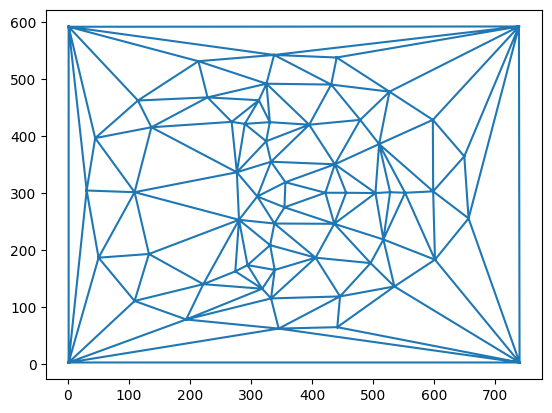

In [29]:
triangulation = mtplb.tri.Triangulation(x, y)
plt.triplot(triangulation)